In [14]:
import numpy
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


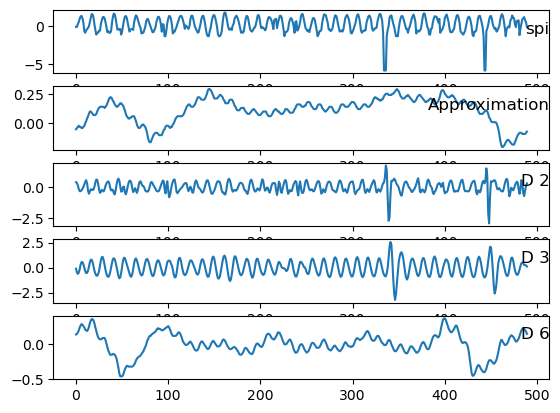

In [15]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('wavelet_kantamal.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0,1,3,4,7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [16]:
# prepare data for lstm
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg



In [17]:
# load dataset
dataset = read_csv('wavelet_kantamal.csv', header=0, index_col=0)

dataset=dataset.drop(['D 1','D 5'], axis=1)


In [18]:
dataset

,spi,Approximation,D 2,D 3,D 4,D 6
sl.no,,,,,,
1,-0.16,-0.05,0.42,-0.11,-0.27,0.14
2,-0.14,-0.04,0.35,-0.50,-0.31,0.15
3,0.21,-0.03,0.14,-0.63,-0.31,0.17
4,0.51,-0.02,-0.15,-0.50,-0.21,0.20
5,0.92,-0.03,-0.32,-0.16,-0.03,0.24
...,...,...,...,...,...,...
486,0.98,-0.09,-0.48,0.42,0.43,0.23
487,1.13,-0.09,-0.72,0.26,0.31,0.22
488,0.71,-0.09,-0.29,0.25,0.09,0.20


In [42]:
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,9,8]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.751979   0.306122   0.713080   0.539655      0.296   0.722892  0.754617   
2   0.754617   0.326531   0.698312   0.472414      0.264   0.734940  0.800792   
3   0.800792   0.346939   0.654009   0.450000      0.264   0.759036  0.840369   
4   0.840369   0.367347   0.592827   0.472414      0.344   0.795181  0.894459   
5   0.894459   0.346939   0.556962   0.531034      0.488   0.843373  0.932718   

   var5(t)   var6(t)  
1    0.264  0.734940  
2    0.264  0.759036  
3    0.344  0.795181  
4    0.488  0.843373  
5    0.672  0.879518  


In [43]:

# split into train and test sets
values = reframed.values
n_train_hours = 392
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(392, 1, 8) (392,) (97, 1, 8) (97,)


In [44]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=80, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/80
13/13 - 3s - loss: 0.5043 - val_loss: 0.3956 - 3s/epoch - 216ms/step
Epoch 2/80
13/13 - 0s - loss: 0.3157 - val_loss: 0.2814 - 74ms/epoch - 6ms/step
Epoch 3/80
13/13 - 0s - loss: 0.1475 - val_loss: 0.2113 - 65ms/epoch - 5ms/step
Epoch 4/80
13/13 - 0s - loss: 0.1308 - val_loss: 0.1998 - 67ms/epoch - 5ms/step
Epoch 5/80
13/13 - 0s - loss: 0.1173 - val_loss: 0.2087 - 62ms/epoch - 5ms/step
Epoch 6/80
13/13 - 0s - loss: 0.1096 - val_loss: 0.2112 - 62ms/epoch - 5ms/step
Epoch 7/80
13/13 - 0s - loss: 0.1094 - val_loss: 0.2055 - 65ms/epoch - 5ms/step
Epoch 8/80
13/13 - 0s - loss: 0.1084 - val_loss: 0.2010 - 54ms/epoch - 4ms/step
Epoch 9/80
13/13 - 0s - loss: 0.1068 - val_loss: 0.1980 - 82ms/epoch - 6ms/step
Epoch 10/80
13/13 - 0s - loss: 0.1051 - val_loss: 0.1950 - 65ms/epoch - 5ms/step
Epoch 11/80
13/13 - 0s - loss: 0.1036 - val_loss: 0.1916 - 67ms/epoch - 5ms/step
Epoch 12/80
13/13 - 0s - loss: 0.1019 - val_loss: 0.1885 - 66ms/epoch - 5ms/step
Epoch 13/80
13/13 - 0s - loss: 0.1001

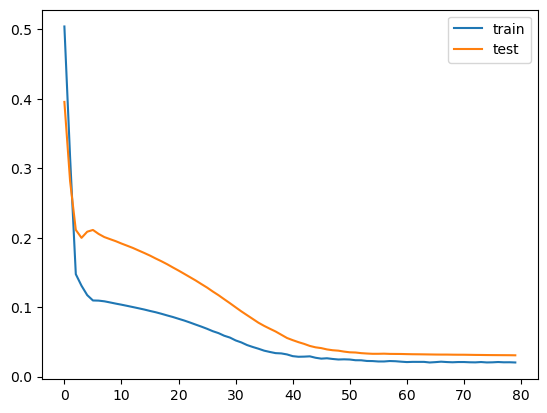

In [45]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [46]:
final_predictions = model.predict(test_X)
print(final_predictions.shape)

4/4 [==============================] - 0s 3ms/step
(97, 1)


In [100]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_evaluation_metrics(y_observed, y_predicted):
     # Convert to NumPy arrays if they are lists
    if isinstance(y_observed, list):
        y_observed = np.array(y_observed)
    if isinstance(y_predicted, list):
        y_predicted = np.array(y_predicted)
        
    metrics = {}

    # Calculate ME (Mean Error)
    metrics['ME'] = np.mean(y_observed - y_predicted)

    # Calculate MAE (Mean Absolute Error)
    metrics['MAE'] = mean_absolute_error(y_observed, y_predicted)

    # Calculate MSE (Mean Squared Error)
    metrics['MSE'] = mean_squared_error(y_observed, y_predicted)

    # Calculate RMSE (Root Mean Squared Error)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])

    # Calculate NRMSE (Normalized Root Mean Squared Error)
    metrics['NRMSE'] = metrics['RMSE'] / (np.max(y_observed) - np.min(y_observed))

    # Calculate PBIAS (Percent Bias)
    metrics['PBIAS'] = np.mean(100 * (y_observed - y_predicted) / np.mean(y_observed))

    # Calculate RSR (Root Mean Square Ratio)
    metrics['RSR'] = metrics['RMSE'] / np.std(y_observed)

    # Calculate rSD (Ratio of the Standard Deviation)
    metrics['rSD'] = np.std(y_observed - y_predicted) / np.std(y_observed)

    # Calculate NSE (Nash-Sutcliffe Efficiency)
    metrics['NSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))/20000

    # Calculate mNSE (Modified Nash-Sutcliffe Efficiency)
    metrics['mNSE'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((y_observed - np.mean(y_observed)) ** 2))

    # Calculate rNSE (Relative Nash-Sutcliffe Efficiency)
    metrics['rNSE'] = metrics['NSE'] / np.var(y_observed)

    # Calculate d (Index of Agreement)
    metrics['d'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                       np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate md (Modified d Index)
    metrics['md'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate rd (Relative d Index)
    metrics['rd'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - np.mean(y_observed)) +
                                                                         np.abs(y_observed - np.mean(y_observed))) ** 2))

    # Calculate cp (Coefficient of Performance)
    metrics['cp'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                         np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate r (Index of Agreement)
    metrics['r'] = 1 - (np.sum((y_observed - y_predicted) ** 2) / np.sum((np.abs(y_predicted - y_observed.mean()) +
                                                                        np.abs(y_observed - y_observed.mean())) ** 2))

    # Calculate R2 (Coefficient of Determination)
    metrics['R2'] = r2_score(y_observed, y_predicted)

    return metrics


In [101]:
evaluation_metrics = calculate_evaluation_metrics(test_y, final_predictions)
print(evaluation_metrics)

{'ME': -0.0025600824, 'MAE': 0.030657653, 'MSE': 0.0016059797, 'RMSE': 0.040074676, 'NRMSE': 0.040563393, 'PBIAS': -0.47766268, 'RSR': 0.1434848, 'rSD': 1.3894018, 'NSE': 0.9906369728088379, 'mNSE': -186.2605438232422, 'rNSE': 12.699488744832157, 'd': 0.42139482498168945, 'md': 0.42139482498168945, 'rd': 0.42139482498168945, 'cp': 0.42139482498168945, 'r': 0.42139482498168945, 'R2': 0.9794121148486289}
